In [50]:
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from SALib.analyze import delta, pawn, rbd_fast, hdmr
from SALib.sample import latin
import MoNeT_MGDrivE as monet
from collections import OrderedDict
import compress_pickle as pkl
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap, ColorConverter
from timeit import default_timer as timer
import json

In [33]:
# GDRIVE = 'SDR'
FILE_NAME = 'SCA_HLT_50Q_10T.csv'
BASE_PATH = '/Users/xingliyu/Desktop/Marshall_lab_summer23'
######################
###  Load dataset  ###
######################
expPath = path.join(BASE_PATH, FILE_NAME)
DATA = pd.read_csv(expPath)
print('* Dataset Path: {}'.format(expPath))
print('* Dataset Dimensions: {}'.format(DATA.shape))
DATA.head()

* Dataset Path: /Users/xingliyu/Desktop/Marshall_lab_summer23/SCA_HLT_50Q_10T.csv
* Dataset Dimensions: (429413, 16)


,i_ren,i_res,i_rei,i_pct,i_pmd,i_mfr,i_mtf,i_fvb,i_grp,TTI,TTO,WOP,POE,POF,CPT,MNF
0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,1876.0,1876.0,0.0,0.0,1.000000,1.000491,0.958860
1,1.0,1.0,7.0,0.9,0.75,0.0,0.75,0.00,0.0,1876.0,1876.0,0.0,0.0,0.900000,0.999062,0.951478
2,1.0,1.0,7.0,0.9,0.75,0.0,0.75,0.05,0.0,1876.0,1876.0,0.0,0.0,0.966667,0.999792,0.953488
3,1.0,1.0,7.0,0.9,0.75,0.0,0.75,0.10,0.0,1876.0,1876.0,0.0,0.0,0.983333,0.999334,0.953996
4,1.0,1.0,7.0,0.9,0.75,0.0,0.75,0.15,0.0,1876.0,1876.0,0.0,0.0,0.950000,0.999355,0.954125


In [34]:
headerInd = list(DATA.columns)
uqVal = {i: len(list(DATA[i].unique())) for i in headerInd}
DATA.shape

(429413, 16)

In [35]:
uqVal

{'i_ren': 53,
 'i_res': 98355,
 'i_rei': 16,
 'i_pct': 98306,
 'i_pmd': 98306,
 'i_mfr': 98315,
 'i_mtf': 98306,
 'i_fvb': 98315,
 'i_grp': 1,
 'TTI': 2134,
 'TTO': 2495,
 'WOP': 3127,
 'POE': 61,
 'POF': 61,
 'CPT': 331005,
 'MNF': 269832}

In [36]:
DATA['POE'].value_counts()

0.000000    360055
1.000000     37481
0.983333      2864
0.966667      2659
0.016667      1672
             ...  
0.383333       125
0.316667       125
0.516667       121
0.416667       113
0.583333       113
Name: POE, Length: 61, dtype: int64

PGS_aux.py

In [37]:
if monet.isNotebook():
    (USR, DRV) = ('dsk', 'PGS')
else:
    (USR, DRV) = sys.argv[1:]

###############################################################################
# System Constants
###############################################################################
(OVW, JOB_DSK, JOB_SRV) = (True, 4, 32)
(SUM, AGG, SPA, REP, SRP) = (True, False, False, False, True)
###############################################################################
# Releases and Populations
###############################################################################
(REL_START, RELEASES) = (50, [365+(7*i) for i in range(10)])
(POP_SIZE, HUM_SIZE, INC_SIZE, XRAN, FZ) = (
    5e3, 1e3, 1000*1.25,
    (REL_START, 5*int(365)), 
    False
)
(STABLE_T, MLR, SAMP_RATE) = (0, False, 1)
MAX_REPS = 80
###############################################################################
# Sensitivity Analysis
###############################################################################
SA_SAMPLES = 2**16
SA_RANGES = (
    ('ren', (1, 52)), 
    ('rer', (1, 50)), 
    ('rei', (1, 15)),
    ('pct', (.5, 1)), 
    ('pmd', (.5, 1)), 
    ('mfr', (0, .5)), 
    ('mtf', (.5, 1)), 
    ('fvb', (0, .5))
)
###############################################################################
# Files and DA constants
#   "ren", "rer", "rei", "pct", "pmd", "mfr", "mtf", "fvb"
#   1e0, 1e8, 1e0, 1e10, 1e10, 1e10, 1e10, 1e10
#   4, 14, 4, 12, 12, 12, 12, 12
###############################################################################
(XP_PTRN, NO_REL_PAT) = ('E_{}_{}_{}_{}_{}_{}_{}_{}-{}_{}_{}.{}', '00')
(DATA_NAMES, DATA_PRE, DATA_PST) = (
    ('TTI', 'TTO', 'WOP', 'RAP', 'MNX', 'CPT', 'CPT'),
    ('ECO', 'HLT', 'TRS', 'WLD'), ('HLT', 'TRS', 'WLD')
)
# Data Analysis ---------------------------------------------------------------
(DATA_HEAD, DATA_SCA, DATA_PAD, DATA_TYPE) = (
    (
        ('i_ren', 1), ('i_res', 2), ('i_rei', 3),
        ('i_pct', 4), ('i_pmd', 5), 
        ('i_mfr', 6), ('i_mtf', 7), ('i_fvb', 8),
        ('i_grp', 10)
    ),
    {
        'i_ren': 1e0,  'i_res': 1e8, 'i_rei': 1e0,
        'i_pct': 1e10, 'i_pmd': 1e10, 
        'i_mfr': 1e10, 'i_mtf': 1e10, 'i_fvb': 1e10,
        'i_grp': 1e0
    },
    {
        'i_ren': 4,  'i_res': 14, 'i_rei': 4,
        'i_pct': 12, 'i_pmd': 12, 
        'i_mfr': 12, 'i_mtf': 12, 'i_fvb': 12,
        'i_grp': 2
    },
    {
        'i_ren': np.int8,   'i_res': np.double, 'i_rei': np.int8,
        'i_pct': np.double, 'i_pmd': np.double, 
        'i_mfr': np.double, 'i_mtf': np.double, 'i_fvb': np.double,
        'i_grp': np.int8
    }
)
(THI, THO, THW, TAP) = (
    [.10, .20, .25, .50, .75, .80, .90],
    [.10, .20, .25, .50, .75, .80, .90],
    [.10, .20, .25, .50, .75, .80, .90],
    [0, 365]
)
# REF_FILE = 'E_0000_00000000000000_0000_000000000000_000000000000_000000000000_000000000000_000000000000'
REF_FILE = 'E_'+'_'.join(['0'*i for i in list(DATA_PAD.values())[:-1]])
###############################################################################
# DICE Plots
###############################################################################
pFeats = (
    ('i_ren', 'linear'), ('i_res', 'linear'), ('i_rei', 'linear'),
    ('i_pct', 'linear'), ('i_pmd', 'linear'),
    ('i_mfr', 'linear'), ('i_mtf', 'linear'), ('i_fvb', 'linear'),
)
DICE_PARS = (
    ('CPT', 0.005, '#4361ee43', (0, 1)),
    ('WOP', 0.050, '#be0aff33', (0, 5*365+50)),
    ('TTO', 0.050, '#9ef01a33', (0, 5*365+50)),
    ('TTI', 0.075, '#23194233', (0, 150)),
    ('MNF', 0.000, '#00B3E643', (0, 1)),
    ('POE', 0.001, '#ff006e22', (0, 1))
)

In [38]:
def selectDepVars(MOI):
    # Select ranges and dependent variable-------------------------------------
    if (MOI == 'WOP') or (MOI == 'TTO'):
        scalers = [1, 1, XRAN]
        (HD_DEP, IND_RAN) = ('0.1', 7)
    elif (MOI == 'TTI'):
        scalers = [1, 1, XRAN]
        (HD_DEP, IND_RAN) = ('0.1', 7)
    elif (MOI == 'RAP'):
        scalers = [1, 100, 90]
        (HD_DEP, IND_RAN) = ('486', 7)
    elif (MOI == 'MNX'):
        scalers = [1, 100, 1]
        (HD_DEP, IND_RAN) = ('min', 7)
    elif (MOI == 'POE'):
        scalers = [1, 100, 1]
        (HD_DEP, IND_RAN) = ('POE', 1) 
    elif (MOI == 'CPT'):
        scalers = [1, 100, 1]
        (HD_DEP, IND_RAN) = ('CPT', 1) 
    elif (MOI == 'DER'):
        scalers = [1, 100, 5]
        (HD_DEP, IND_RAN) = ('DER', 5) 
    elif (MOI == 'MNF'):
        scalers = [1, 1, 1]
        (HD_DEP, IND_RAN) = ('MNF', 1) 
    # Color Mapping -----------------------------------------------------------
    if MOI == 'WOP':
        cmap = colorPaletteFromHexList(['#ffffff00', '#03045eAA'])
    elif MOI == 'CPT':
        cmap = colorPaletteFromHexList(['#ffffff00', '#3a86ffAA'])
    elif MOI == 'POE':
        cmap = colorPaletteFromHexList(['#ffffff00', '#8338ECAA'])
    else:
        cmap = colorPaletteFromHexList(['#ffffff00', '#3b479dAA'])
    return (scalers, HD_DEP, IND_RAN, cmap)


In [39]:
###############################################################################
# Dependent Variables for Heatmaps
###############################################################################
def colorPaletteFromHexList(clist):
    c = ColorConverter().to_rgba
    clrs = [c(i) for i in clist]
    rvb = LinearSegmentedColormap.from_list("", clrs)
    return rvb

In [40]:
def landSelector():
    PAN = ([0], )
    return PAN

In [41]:
###############################################################################
# Paths
###############################################################################
def selectPath(USR, DRV=None):
    if USR == 'srv':
        PATH_ROOT = '/RAID5/marshallShare/pgSIT2/{}/'.format(DRV)
    elif USR == 'dsk':
        PATH_ROOT = '/Users/xingliyu/Desktop/Marshall_lab_summer23/WorkSims/pgSIT2/{}/'.format(DRV)
    (PATH_IMG, PATH_DATA) = (
        '{}img/'.format(PATH_ROOT), 
        '{}'.format(PATH_ROOT)
    )
    PATH_PRE = PATH_DATA + 'PREPROCESS/'
    PATH_OUT = PATH_DATA + 'POSTPROCESS/'
    PATH_MTR = PATH_DATA + 'SUMMARY/'
    fldrList = [PATH_ROOT, PATH_IMG, PATH_DATA, PATH_PRE, PATH_OUT, PATH_MTR]
    [monet.makeFolder(i) for i in fldrList]
    return (PATH_ROOT, PATH_IMG, PATH_DATA, PATH_PRE, PATH_OUT, PATH_MTR)

FMS_gene.py

In [42]:
###############################################################################
# Drive
###############################################################################
def driveSelector(DRIVE, TYPE, popSize=(100*12000)):
    ###########################################################################
    if (DRIVE == 'FMS3'):
        (aggD, yRange, folder) = FMS3.driveParameters(TYPE, popSize)
    elif (DRIVE == 'FMS4'):
        (aggD, yRange, folder) = FMS4.driveParameters(TYPE, popSize)
    elif (DRIVE == 'FMS5'):
        (aggD, yRange, folder) = FMS5.driveParameters(TYPE, popSize)
    elif (DRIVE == 'PGS'):
        (aggD, yRange, folder) = driveParameters(TYPE, popSize)
    elif (DRIVE == 'IIT'):
        (aggD, yRange, folder) = IIT.driveParameters(TYPE, popSize)
    elif (DRIVE == 'RDL'):
        (aggD, yRange, folder) = RDL.driveParameters(TYPE, popSize)
    elif (DRIVE == 'RDF'):
        (aggD, yRange, folder) = RDF.driveParameters(TYPE, popSize)
    else:
        print("Error in gene drive ID")
    ###########################################################################
    if TYPE == 'ECO':
        colors = [
            '#2614ed55', '#FF006E55', '#45d40c55', '#8338EC55', '#1888e355', 
            '#BC109755', '#FFE93E55', '#3b479d55', '#540d6e55', '#7bdff255'
        ]
    elif TYPE == 'HLT':
        if DRIVE == 'FMS3':
            colors = ['#1888e300', '#2614ed00', '#f2008935']
        elif DRIVE == 'FMS4':
            colors = ['#1888e300', '#2614ed00', '#3b479d35']
        elif DRIVE == 'FMS5':
            colors = ['#1888e300', '#2614ed00', '#45d40c35']
        elif DRIVE == 'PGS':
            colors = ['#1888e335', '#2614ed35', '#8338EC35']
        elif DRIVE == 'IIT':
            colors = ['#f2008900', '#c879ff00', '#540d6e35']
        elif DRIVE == 'RDL':
            colors = ['#f2008900', '#c879ff00', '#bbdefb35']
        elif DRIVE == 'RDF':
            colors = ['#f2008900', '#c879ff00', '#1888e335']
        else:
            colors = ['#f2008955', '#c879ff55', '#c879ff35']
    elif TYPE == 'TRS':
        colors = monet.COLTN
    elif TYPE == 'WLD':
        colors = monet.COLWN
    elif TYPE == 'HUM':
        colors = ['#274c7700', '#c879ff99', '#dee2ff55']
    elif TYPE == 'INC':
        colors = ['#8CD9FF00', '#bbdefb55', '#dee2ff00']
    ###########################################################################
    geneDict = {
        'gDict': aggD, 'yRange': yRange, 'colors': colors, 'folder': folder
    }
    return geneDict

PGS_gene_PGS.py

In [43]:
###############################################################################
# Souce: https://github.com/Chipdelmal/MGDrivE/blob/master/Main/pgSIT_Femaless/cubePgSIT.R
#   A/a: Cas locus, 
#   B/b: gRNA locus, 
#   C/c: female viability target site 1
#   D/d: female viability target site 2
#   E/e: female viability target site 3
#   ...
#   X/x: male fertility target site
###############################################################################
genotypes = (
    "AABBCCDD", "aABBCCDD", "AAbBCCDD", "aAbBCCDD", "AABBcCDD", "aABBcCDD", 
    "AAbBcCDD", "aAbBcCDD", "AABBCCdD", "aABBCCdD", "AAbBCCdD", "aAbBCCdD", 
    "AABBcCdD", "aABBcCdD", "AAbBcCdD", "aAbBcCdD", "aaBBCCDD", "aabBCCDD", 
    "aaBBcCDD", "aabBcCDD", "aaBBCCdD", "aabBCCdD", "aaBBcCdD", "aabBcCdD", 
    "AAbbCCDD", "aAbbCCDD", "AAbbcCDD", "aAbbcCDD", "AAbbCCdD", "aAbbCCdD", 
    "AAbbcCdD", "aAbbcCdD", "aabbCCDD", "aabbcCDD", "aabbCCdD", "aabbcCdD",
    "AABBccDD", "aABBccDD", "AAbBccDD", "aAbBccDD", "AABBccdD", "aABBccdD", 
    "AAbBccdD", "aAbBccdD", "aaBBccDD", "aabBccDD", "aaBBccdD", "aabBccdD", 
    "AAbbccDD", "aAbbccDD", "AAbbccdD", "aAbbccdD", "aabbccDD", "aabbccdD", 
    "AABBCCdd", "aABBCCdd", "AAbBCCdd", "aAbBCCdd", "AABBcCdd", "aABBcCdd", 
    "AAbBcCdd", "aAbBcCdd", "aaBBCCdd", "aabBCCdd", "aaBBcCdd", "aabBcCdd", 
    "AAbbCCdd", "aAbbCCdd", "AAbbcCdd", "aAbbcCdd", "aabbCCdd", "aabbcCdd", 
    "AABBccdd", "aABBccdd", "AAbBccdd", "aAbBccdd", "aaBBccdd", "aabBccdd", 
    "AAbbccdd", "aAbbccdd", "aabbccdd"
)
(locA, locB, locC, locD) = ((0, 1), (2, 3), (4, 5), (6, 7))
###############################################################################
# Ecology genotype counts
###############################################################################
ECO_DICT = OrderedDict((
    ('A', (('A', locA), )), ('a', (('a', locA), )),
    ('B', (('B', locB), )), ('b', (('b', locB), )),
    ('C', (('C', locC), )), ('c', (('c', locC), )),
    ('D', (('D', locD), )), ('d', (('d', locD), ))
))
PGS_ECO = monet.geneFrequencies(ECO_DICT, genotypes)

###############################################################################
# Health genotype counts (gRNA)
###############################################################################
HLT_DICT = OrderedDict((
    ('T*',   (('A', locA), ('B', locB), ('C', locC), ('D', locD))),
    ('O-',   (('a', locA), ('b', locB), ('c', locC), ('d', locD)))
))
PGS_HLT = monet.carrierFrequencies(HLT_DICT, genotypes)
PGS_HLT = [PGS_HLT[0], [PGS_HLT[1][0], PGS_HLT[1][-1], PGS_HLT[1][-1]]]

###############################################################################
# Trash genotype counts (Cas9)
###############################################################################
TRS_DICT = OrderedDict((
    ('Cas9*',   (('A', locA), )),
    ('O-',      (('a', locA), ))
))
PGS_TRS = monet.carrierFrequencies(TRS_DICT, genotypes)

###############################################################################
# Wild genotype counts
###############################################################################
WLD_DICT = OrderedDict((
    ('O*', (('A', locA), ('B', locB), ('C', locC), ('D', locD))),
    ('W-', (('a', locA), ('b', locB), ('c', locC), ('d', locD)))
))
PGS_WLD = monet.carrierFrequencies(WLD_DICT, genotypes, invert=False)

###############################################################################
# Drive Selector
###############################################################################
def driveParameters(TYPE, popSize):
    if TYPE == 'ECO':
        aggD = monet.generateAggregationDictionary(*PGS_ECO)
        yRange = popSize*4
    elif TYPE == 'HLT':
        aggD = monet.generateAggregationDictionary(*PGS_HLT)
        yRange = popSize
    elif TYPE == 'TRS':
        aggD = monet.generateAggregationDictionary(*PGS_TRS)
        yRange = popSize/2
    elif TYPE == 'WLD':
        aggD = monet.generateAggregationDictionary(*PGS_WLD)
        yRange = popSize/2
    return (aggD, yRange, 'pgSIT')

PGS_saSampler.py

In [44]:
DRV = 'PGS'

In [45]:
###############################################################################
# Setting Paths Up and Reading SA Constants
###############################################################################
(SAMPLES_NUM, VARS_RANGES) = (SA_SAMPLES, SA_RANGES)
(drive, land) = (
    driveSelector(DRV, 'HLT', popSize=POP_SIZE), landSelector()
)
(gene, fldr) = (drive.get('gDict'), drive.get('folder'))
(PT_ROT, PT_IMG, PT_DTA, PT_PRE, PT_OUT, PT_MTR) = selectPath(USR, fldr)
###############################################################################
# V1: Model Inputs
###############################################################################
saVars = ([i for i in VARS_RANGES if (len(i[1])>1)])
(saNames, saBounds) = list(zip(*saVars))
saNum = len(saVars)

In [46]:
# SA Problem Definition -------------------------------------------------------
problem = {
    'num_vars': saNum,  'names': saNames, 
    'bounds': saBounds, 'dists': ['unif']*saNum
}
###############################################################################
# Sampling
###############################################################################
param_values = latin.sample(problem, SAMPLES_NUM)
df = pd.DataFrame(param_values, columns=saNames)
df['ren'] = [int(i) for i in round(df['ren'])]
###############################################################################
# Ammending Experiments DF
###############################################################################
rows = df.shape[0]
cstVars = ([i for i in VARS_RANGES if (len(i[1])<=1)])
for (var, cstVal) in cstVars:
    df[var]=cstVal*rows
df = df[[i[0] for i in VARS_RANGES]]
df

,ren,rer,rei,pct,pmd,mfr,mtf,fvb
0,51,9.952546,8.099019,0.714159,0.698609,0.234544,0.684231,0.286488
1,6,20.516007,7.383025,0.750419,0.554798,0.375418,0.617458,0.467717
2,43,36.797808,4.450996,0.757657,0.663116,0.159082,0.860970,0.344770
3,5,32.800099,4.768447,0.699757,0.936091,0.256226,0.715311,0.104396
4,8,30.547035,14.447476,0.807120,0.654615,0.115185,0.645142,0.328582
...,...,...,...,...,...,...,...,...
65531,46,7.104414,12.998782,0.703783,0.617449,0.233806,0.643925,0.175722
65532,19,34.808865,8.501219,0.772423,0.621906,0.022861,0.504125,0.409095
65533,29,4.612354,5.064511,0.783181,0.722923,0.467698,0.670335,0.004035
65534,23,11.400271,14.192118,0.760559,0.519687,0.089823,0.937560,0.421642


In [47]:
###############################################################################
# Export
###############################################################################
df.to_csv(path.join(PT_MTR, 'SA_experiment.csv'), index=False)
pkl.dump(problem, path.join(PT_MTR, 'SA_experiment.pkl'))
with open(path.join(PT_MTR, 'SA_experiment.npy'), 'wb') as f:
    np.save(f, param_values)

PGS_saAnalyzer.py

In [48]:
if monet.isNotebook():
    (USR, DRV, QNT, AOI, THS, MOI) = ('dsk', 'PGS', '50', 'HLT', '0.1', 'CPT')
else:
    (USR, DRV, QNT, AOI, THS, MOI) = sys.argv[1:]
###############################################################################
# Setting Paths Up and Reading SA Constants
###############################################################################
(SAMPLES_NUM, VARS_RANGES) = (SA_SAMPLES, SA_RANGES)
(drive, land) = (
    driveSelector(DRV, 'HLT', popSize=POP_SIZE), landSelector()
)
(gene, fldr) = (drive.get('gDict'), drive.get('folder'))
(PT_ROT, PT_IMG, PT_DTA, PT_PRE, PT_OUT, PT_MTR) = selectPath(USR, fldr)

###############################################################################
# V2: PGS_saSampler.py
###############################################################################
PT_OUT = path.join(PT_ROT, 'ML')
PT_IMG = path.join(PT_OUT, 'img')
[monet.makeFolder(i) for i in [PT_OUT, PT_IMG]]
PT_SUMS = path.join(PT_ROT, 'SUMMARY')
# Time and head -----------------------------------------------------------
tS = datetime.now()
monet.printExperimentHead(
    PT_ROT, PT_OUT, tS, 
    '{} SA Analyzer [{}:{}:{}]'.format(DRV, AOI, THS, MOI)
)
###############################################################################
# Read SA Files
###############################################################################
(PROBLEM, SAMPLER, EXP) = (
    pkl.load(path.join(PT_MTR, 'SA_experiment.pkl')),
    np.load(path.join(PT_MTR, 'SA_experiment.npy')),
    pd.read_csv(path.join(PT_MTR, 'SA_experiment.csv'))
)
###############################################################################
# Read Results CSV
###############################################################################
thsStr = str(int(float(THS)*100))
(fName_I, fName_R, fName_C) = (
    'SCA_{}_{}Q_{}T.csv'.format(AOI, QNT, thsStr),
    'REG_{}_{}Q_{}T.csv'.format(AOI, QNT, thsStr),
    'CLS_{}_{}Q_{}T.csv'.format(AOI, QNT, thsStr)
)
RES = pd.read_csv(path.join(PT_OUT, fName_I))

path.join(PT_OUT, fName_I)

* [2023-09-28 23:22:11.651672] MoNeT PGS SA Analyzer [HLT:0.1:CPT]
* I: /Users/xingliyu/Desktop/Marshall_lab_summer23/WorkSims/pgSIT2/pgSIT/
* O: /Users/xingliyu/Desktop/Marshall_lab_summer23/WorkSims/pgSIT2/pgSIT/ML


'/Users/xingliyu/Desktop/Marshall_lab_summer23/WorkSims/pgSIT2/pgSIT/ML/SCA_HLT_50Q_10T.csv'

In [49]:
###############################################################################
# Explore
###############################################################################
headerInd = list(RES.columns)
uqVal = {i: len(list(RES[i].unique())) for i in headerInd}
resNum = RES.shape
###############################################################################
# Read SA Files
###############################################################################
(PROBLEM, SAMPLER, EXP) = (
    pkl.load(path.join(PT_MTR, 'SA_experiment.pkl')),
    np.load(path.join(PT_MTR, 'SA_experiment.npy')),
    pd.read_csv (path.join(PT_MTR, 'SA_experiment.csv'))
)
###############################################################################
# Assemble Output Vector
###############################################################################
headExp = list(RES.columns)
headRes = [i for i in RES.columns if i[0]=='i']
saVars = set([i[0] for i in ([i for i in VARS_RANGES if (len(i[1])>1)])])
saCnst = set([i[0] for i in ([i for i in VARS_RANGES if (len(i[1])<=1)])])
rsnst = set([i.split('_')[-1] for i in headRes]) - set(PROBLEM['names'])
# Generate filter -------------------------------------------------------------
(FEATS, LABLS) = (
    [i for i in headerInd if i[0]=='i'], 
    [i for i in headerInd if i[0]!='i']
)
FEATS = [i for i in FEATS if uqVal[i]>1]
bounds = [(min(RES[i]), max(RES[i])) for i in FEATS]
problem = {
    'num_vars': len(FEATS),
    'names': FEATS,
    'bounds': bounds,
    'dists': ['unif']*len(FEATS),
    'sample_scaled': True
}
(X, Y) = (np.asarray(RES[FEATS]), np.asarray(RES[MOI]))

## Calculate computational efficiency for 4 SA methods

In [25]:
time = timer()
print(time)
timers = {'start': time}

SA_delta = delta.analyze(PROBLEM, X, Y, print_to_console=False)
timers['Delta'] = (timer()-timers['start'])
print('Delta_time: ', timers['Delta'])

timers['start'] = timer()
SA_pawn = pawn.analyze(PROBLEM, X, Y, print_to_console=False)
timers['PAWN'] = (timer()-timers['start'])
print('PAWN_time: ', timers['PAWN'])

timers['start'] = timer()
SA_hdmr = hdmr.analyze(PROBLEM, X, Y, print_to_console=False)
timers['HDMR'] = (timer()-timers['start'])
print('HDMR_time: ', timers['HDMR'])

timers['start'] = timer()
SA_fast = rbd_fast.analyze(PROBLEM, X, Y, print_to_console=False)
timers['FAST'] = (timer()-timers['start'])
print('FAST_time: ', timers['FAST'])

7.237447974
Delta_time:  937.886798256
PAWN_time:  4.9074987029999875
HDMR_time:  670.6003651750001
FAST_time:  35.45677298500004


In [51]:
with open(path.join(PT_OUT, 'ISCI_SHAP_time.json'), 'r') as f:
    ML = json.load(f)
    
timers['ISCI*'] = ML['ISCI*']
timers['SHAP*'] = ML['SHAP*']

In [52]:
timers

{'Delta': 937.886798256,
 'PAWN': 4.9074987029999875,
 'HDMR': 670.6003651750001,
 'FAST': 35.45677298500004,
 'ISCI*': 0.11940266799999932,
 'SHAP*': 47.05460373}

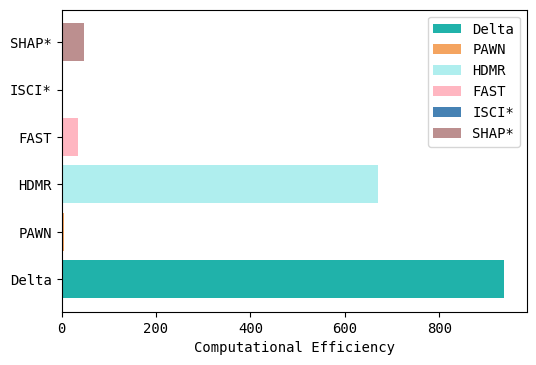

In [53]:
keys = timers.keys()
values = timers.values()
colors = ['lightseagreen' ,'sandybrown', 'paleturquoise','lightpink','steelblue', 'rosybrown']

plt.figure(dpi=100)

for k, v, c in zip(keys, values, colors):
    plt.barh(k, v, color = c, label=k)

plt.xlabel("Computational Efficiency")    
plt.legend(loc="upper right")
plt.show()

In [29]:
# Compile dataframes ----------------------------------------------------------
deltaDF = pd.DataFrame(SA_delta)
pawnDF = pd.DataFrame(SA_pawn)
hdmrDF = pd.DataFrame({'S1': SA_hdmr['Sa'], 'S1_conf': SA_hdmr['Sa_conf'], 'names': SA_hdmr['names']})
fastDF = pd.DataFrame(SA_fast)

In [31]:
###############################################################################
# Export to Disk
###############################################################################
outPairs = list(zip(
    ['Delta', 'PAWN', 'HDMR', 'FAST'],
    [deltaDF, pawnDF, hdmrDF, fastDF], 
    [SA_delta, SA_pawn, SA_hdmr, SA_fast]
))
for (name, df, dct) in outPairs:
    fName = path.join(PT_MTR, f'SAC-{AOI}_{MOI}-{name}-{QNT}_qnt')
    df.to_csv(fName+'.csv', index=False)
    pkl.dump(dct, fName+'.pkl')